In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
def create_net_capital(x):
    temp = x.copy()
    temp['net capital'] = temp['capital-gain'] - temp['capital-loss']
    return temp

In [5]:
global_transformations = [
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [6]:
params_dict = dict(
    n_estimators=[4000, 4250, 4500],
    learning_rate=[0.425, 0.45, 0.475, 0.5],
    #max_features=[0.2, 0.25, 0.3, 0.35, 0.4],
    #max_depth=[2, 3, 4],    
    #min_samples_split=[0.65, 0.7, 0.75],
    #min_samples_leaf=[0.003, 0.0035, 0.004, 0.0045, 0.005],
    #class_weight=[None, 'balanced', {'<=50K': 1, '>50K': 2}, {'<=50K': 2, '>50K': 1}, {'<=50K': 4, '>50K': 1}],
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,n_estimators,learning_rate
0,4000,0.425
1,4000,0.450
2,4000,0.475
3,4000,0.500
4,4250,0.425
5,4250,0.450
6,4250,0.475
7,4250,0.500
8,4500,0.425
9,4500,0.450


In [7]:
hyper_param_object = oo.AdaBoostClassifierHP(
    n_estimators=1869,
    learning_rate=1.0,
    algorithm='SAMME.R',
    # Tree-specific hyper-params
    criterion='gini',
    splitter='best',
    max_features=0.3,  # tuned
    max_depth=2,  # tuned
    min_samples_split=0.7,  # tuned
    min_samples_leaf=0.004,  # tuned
    min_weight_fraction_leaf=0.,
    max_leaf_nodes=None,
    min_impurity_decrease=0.,
    class_weight=None,
)

In [8]:
model=oo.AdaBoostClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_Adaboost'
resampler_cache_directory = 'tuner_Adaboost_resample_cache'

In [11]:
score_list = [oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      parallelization_cores=-1,
                      #parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [14]:
params_dict

{'n_estimators': [4000, 4250, 4500],
 'learning_rate': [0.425, 0.45, 0.475, 0.5]}

In [15]:
tuner.results.best_hyper_params

{'n_estimators': 4250, 'learning_rate': 0.45}

In [16]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.9289658151291172,
 'F_BETA': 0.7537722241036691,
 'sensitivity': 0.6650168895774823,
 'positive_predictive_value': 0.779848500163165}

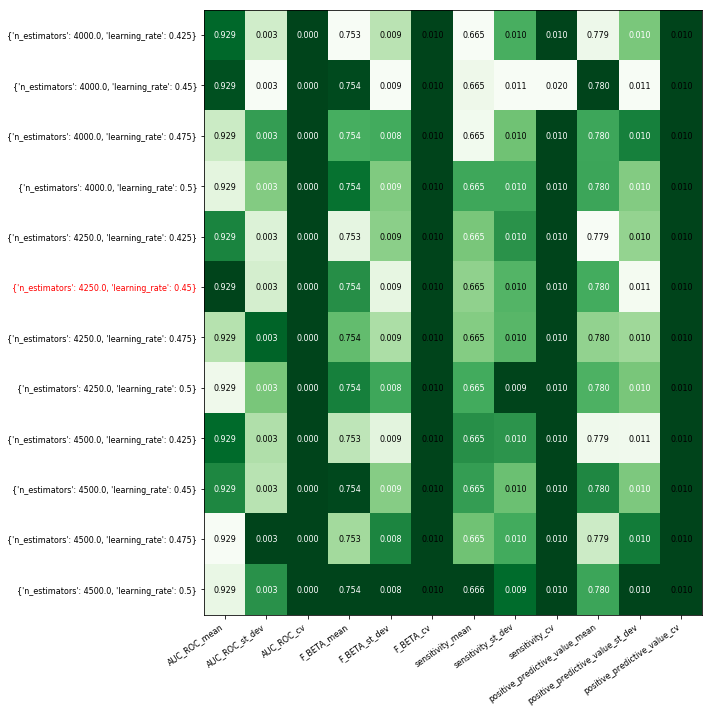

In [17]:
tuner.results.plot_resampled_stats()

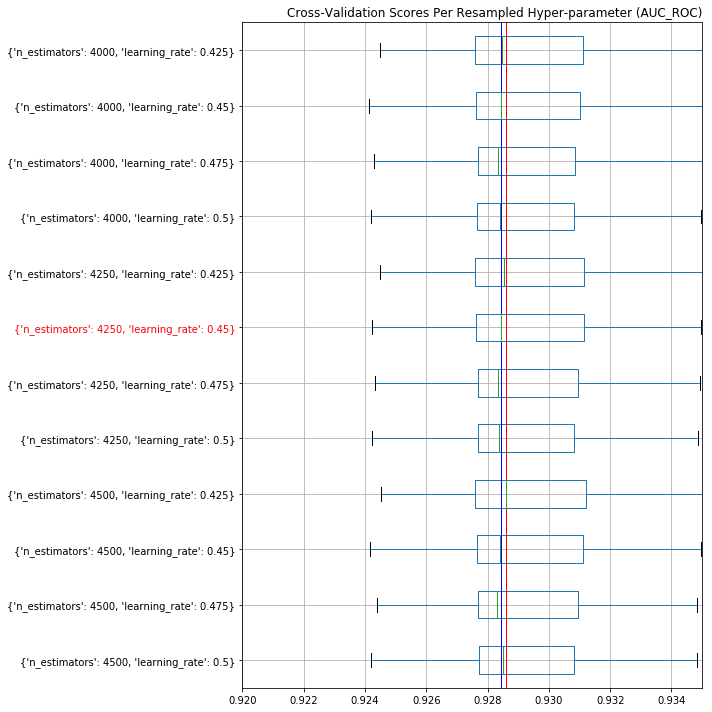

In [18]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.92, 0.935),
                                    show_one_ste_rule=True
                                   )

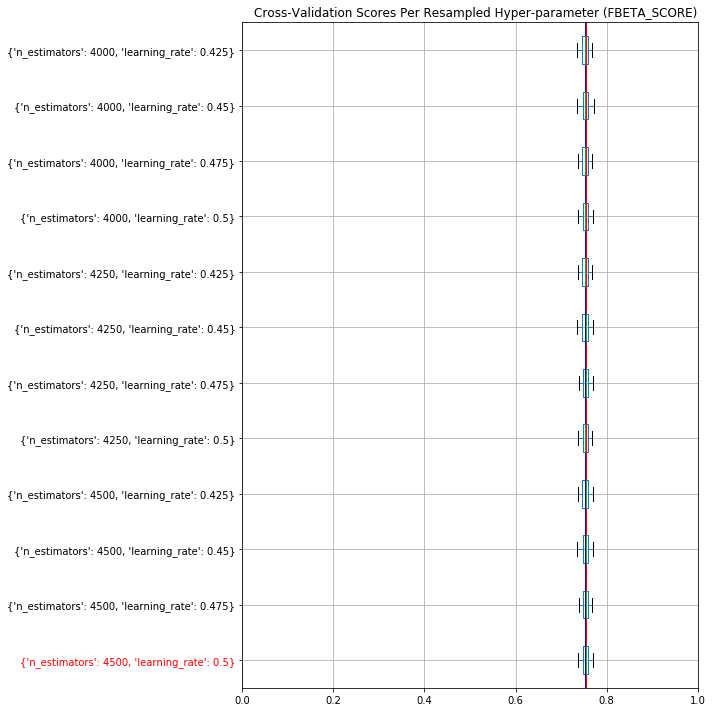

In [19]:
tuner.results.plot_resampled_scores(oo.Metric.FBETA_SCORE,
#                                    x_axis_limits=(0.725, 0.77),
                                    show_one_ste_rule=True
                                   )

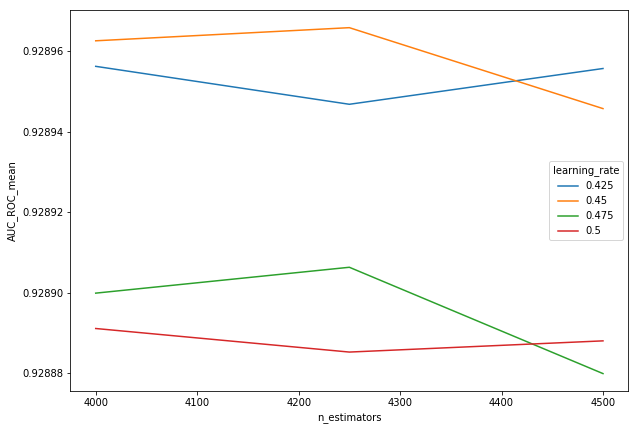

In [20]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='n_estimators',
                                        line='learning_rate',)

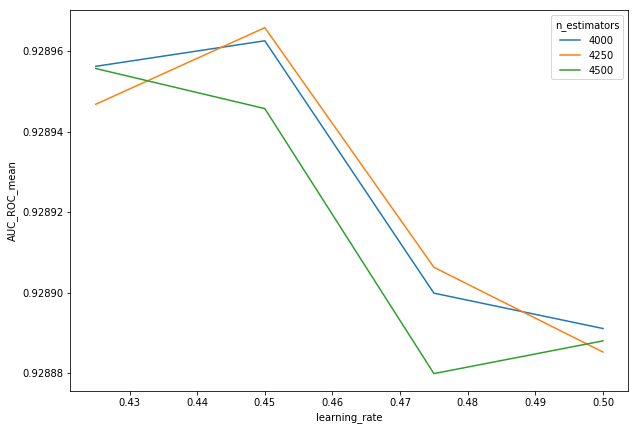

In [21]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
                                        line='n_estimators')

In [22]:
tuner.results.best_hyper_params

{'n_estimators': 4250, 'learning_rate': 0.45}

In [23]:
assert False

AssertionError: 

# Final Tune

In [24]:
final_hyper_param_object = oo.AdaBoostClassifierHP(
    n_estimators=4250,
    learning_rate=0.45,
    algorithm='SAMME.R',
    # Tree-specific hyper-params
    criterion='gini',
    splitter='best',
    max_features=0.3,  # tuned
    max_depth=2,  # tuned
    min_samples_split=0.7,  # tuned
    min_samples_leaf=0.004,  # tuned
    min_weight_fraction_leaf=0.,
    max_leaf_nodes=None,
    min_impurity_decrease=0.,
    class_weight=None,  # tuned
)
final_model = oo.AdaBoostClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [25]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(threshold=0.5,
                                                  positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9348694400701697,
 'AUC Precision/Recall': 0.8452966650109882,
 'Kappa': 0.6451612539978099,
 'F1 Score': 0.7260815107428461,
 'Two-Class Accuracy': 0.8742647384016629,
 'Error Rate': 0.1257352615983371,
 'True Positive Rate': 0.6723768736616702,
 'True Negative Rate': 0.9407890868465926,
 'False Positive Rate': 0.05921091315340742,
 'False Negative Rate': 0.32762312633832974,
 'Positive Predictive Value': 0.789109947643979,
 'Negative Predictive Value': 0.8970621215519174,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [26]:
trainer.training_scores[0].value

0.9348694400701697

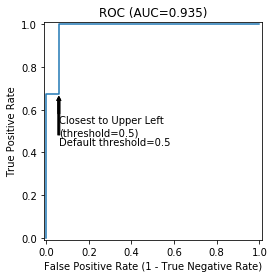

In [27]:
trainer.training_evaluator.plot_roc_curve()

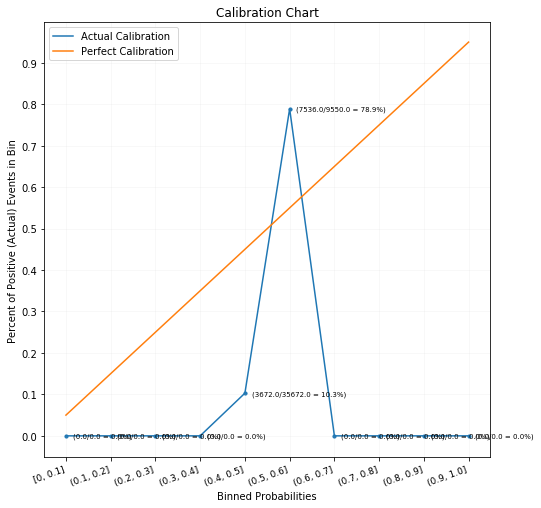

In [35]:
trainer.training_evaluator.plot_calibration()

In [28]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [29]:
test_dataset.head(100)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [31]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
test_converter = oo.TwoClassThresholdConverter(threshold=0.5,
                                               positive_class=positive_class)
predictions.head()

,<=50K,>50K
0,0.500762,0.499238
1,0.499882,0.500118
2,0.500123,0.499877
3,0.498034,0.501966
4,0.500413,0.499587


In [32]:
class_predictions = test_converter.convert(predictions)
class_predictions[0:5]

array(['<=50K', '>50K', '<=50K', '>50K', '<=50K'], dtype='<U5')

In [33]:
# previous_predictions = pd.read_csv('submission_5_xgb.csv')
# previous_predictions.head(10)

In [37]:
income_value = predictions['>50K']#[0 if x == '<=50K' else 1 for x in class_predictions]
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_11_Adaboost.csv', index=False)

In [ ]:
# # e.g. lower threshold will change 0's to 1's so new - previous will give number predictions that changed to 1
# difference = new_predictions.income - previous_predictions.income
# difference.sum() / len(difference)

# Results

## 1)

Kaggle Public: `0.93482`

File: `submission_11_Adaboost.csv`

Parameters: 

```
n_estimators=4250,
learning_rate=0.45,
algorithm='SAMME.R',
# Tree-specific hyper-params
criterion='gini',
splitter='best',
max_features=0.3,  # tuned
max_depth=2,  # tuned
min_samples_split=0.7,  # tuned
min_samples_leaf=0.004,  # tuned
min_weight_fraction_leaf=0.,
max_leaf_nodes=None,
min_impurity_decrease=0.,
class_weight=None,  # tuned
```

Originally had Mean Resampler Results of:

```
'AUC_ROC': 0.9289658151291172,
'F_BETA': 0.7537722241036691,
'sensitivity': 0.6650168895774823,
'positive_predictive_value': 0.779848500163165}
```